#0.0. IMPORTS

In [1]:
pip install boruta

In [2]:
import warnings
import random
import requests
import json
import math
import pickle
import os

import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as stats
import xgboost             as xgb

from sklearn                   import model_selection  as ms
from imblearn.under_sampling   import NearMiss
from boruta                    import BorutaPy
from sklearn.preprocessing     import LabelEncoder,RobustScaler,MinMaxScaler
from sklearn.ensemble          import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics           import precision_score, recall_score, f1_score
from sklearn.metrics           import roc_curve, auc,accuracy_score,confusion_matrix
from sklearn.linear_model      import LinearRegression,Lasso,LogisticRegression
from tabulate                  import tabulate
from IPython.display           import Image
from sklearn                   import tree,metrics
from sklearn.neighbors         import KNeighborsClassifier 
from sklearn.naive_bayes       import GaussianNB,BernoulliNB
from flask                     import Flask, request,Response
from sklearn.tree              import ExtraTreeClassifier,DecisionTreeClassifier
from sklearn.model_selection   import StratifiedKFold,cross_val_predict,train_test_split


warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


##0.1 Helper Functions

In [3]:
def plot_numeric_categorical(feature,feature_response,data):
  
  plt.subplot(2,2,1)
  ax=sns.barplot(x=feature_response,y=feature,data=df4)
  ax.figure.set_size_inches(12,6)

  plt.subplot(2,2,2)
  sns.boxplot(x=feature_response,y=feature,data=df4)

  plt.subplot(2,2,3)
  numeric_categorical(feature,feature_response,df4)

  return ax


def numeric_categorical(feature,feature_response,data):
  aux=data.copy()
  aux[feature_response]=aux[feature_response].apply(lambda x: 1 if x=='satisfied' else 0)
  correlation=aux[[feature,feature_response]].corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  return ax


def categorical_categorical(feature,feature_response,data):
  aux=data.copy()
  aux[feature_response]=aux[feature_response].apply(lambda x: 1 if x=='satisfied' else 0)
  aux[feature]=aux[feature].astype(int)
  correlation=aux[[feature,feature_response]].corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  return ax


def correlation_numeric(numericos,data):

  columns=numericos.columns
  aux=data[columns]

  correlation=aux.corr(method='pearson')
  ax=sns.heatmap(correlation,annot=True);
  ax.figure.set_size_inches(10,5)
  ax.set_title('Correlation between numerical features',fontsize=14)

  return ax


def descriptive_statistics(data):

  #select
  num_attributes=data.select_dtypes(include=['int64','float64'])

  #Central tendency=mean,median
  ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
  ct2=pd.DataFrame(num_attributes.apply(np.median)).T

  #Dispersion=std,min,max,range,skew,kurtosis
  d1=pd.DataFrame(num_attributes.apply(np.std)).T
  d2=pd.DataFrame(num_attributes.apply(min)).T
  d3=pd.DataFrame(num_attributes.apply(max)).T
  d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
  d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
  d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

  #Concatenate
  aux=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
  aux.columns=(['Attributes','Min','Max','Range','Mean','Median','Std','Skew','Kurtosis']) 

  return aux


def cramer_v(x,y):  
  cm=pd.crosstab(x, y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)
  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def model_performance(y_test,yhat,name):
  dataframe=pd.DataFrame({ 'Model Name':   name,                                                                                                   
                           'Precision':    precision_score(y_test,yhat),                           
                           'Recall':       recall_score(y_test,yhat),
                           'F1Score':      f1_score(y_test,yhat),
                           'Accuracy':     accuracy_score(y_test,yhat)
                         },index=[0])
  return dataframe


def cross_validation(num_folds,x_train,y_train,model_name,model):  

  precision_list=[]
  f1_score_list=[]
  recall_list=[]
  accuracy_list=[]

  #generate k-fold  
  kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=32)

  for train_ix , val_ix in kfold.split(x_train,y_train):

    #get fold
    x_train_fold=x_train.iloc[train_ix]
    y_train_fold=y_train.iloc[train_ix]

    x_val_fold=x_train.iloc[val_ix]
    y_val_fold=y_train.iloc[val_ix]

    #model
    m=model.fit(x_train_fold,y_train_fold)

    #prediction
    yhat=m.predict(x_val_fold)

    #performance
    performaces=model_performance(y_val_fold,yhat,model_name)

    #performance of each KFold iteration
    precision_list.append(performaces['Precision'])
    f1_score_list.append(performaces['F1Score'])
    recall_list.append(performaces['Recall'])
    accuracy_list.append(performaces['Accuracy'])      


    return pd.DataFrame({ 'ModelName':               model_name,                        
                          'PrecisionCV':             np.round(np.mean(precision_list),2).astype(str)+ '+/-' + np.round(np.std(precision_list),2).astype(str),
                          'RecallCV':                np.round(np.mean(recall_list),2).astype(str)+ '+/-' +np.round(np.std(recall_list),2).astype(str),
                          'F1ScoreCV':               np.round(np.mean(f1_score_list),2).astype(str)+ '+/-' + np.round(np.std(f1_score_list),2).astype(str),                        
                          'AccuracyCV':              np.round(np.mean(accuracy_list),2).astype(str)+ '+/-' +np.round(np.std(accuracy_list),2).astype(str)
                        
                        },index=[0])
  

def boruta (x_train,y_train):
  
  #Training and test dataset for Boruta
  X_train_boruta = x_train.values
  Y_train_boruta = y_train.values.ravel()

  #Define RandomForestRegressor
  rf=RandomForestRegressor(n_jobs=-1)

  #Define Boruta
  boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(X_train_boruta,Y_train_boruta)  
  
  return boruta
  

def best_features(boruta,x_train):

  cols_selected=boruta.support_.tolist()

  #best features
  x_train_fs=x_train
  cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

  #not selected boruta
  cols_not_selected_boruta=list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

  return cols_selected_boruta


def plot_categorical_categorical(feature,feature_response,data):
  plt.subplot(2,2,1)
  aux=df4.copy()
  aux[feature]=aux[feature].astype(int)
  ax=sns.boxplot(y=feature,x=feature_response,data=aux)
  ax.figure.set_size_inches(12,6)

  plt.subplot(2,2,2)
  aux=df4.copy()
  aux[feature]=aux[feature].astype(int)
  ax=sns.barplot(y=feature,x=feature_response,data=aux)

  plt.subplot(2,2,3)
  categorical_categorical(feature,feature_response,df4)
  return ax

##0.2 Loading Data

In [4]:
df_raw=pd.read_csv('/content/train.csv')
df_raw.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.000,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.000,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.000,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.000,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.000,satisfied


# 1.0. DESCRIPTION OF THE DATA

In [5]:
df1=df_raw.copy()

##1.1 Rename Columns

In [6]:
columns={  'Unnamed: 0'                       :'Unnamed: 0',
           'id'                               :'Id',
           'Gender'                           :'Gender',
           'Customer Type'                    :'CustomerType',
           'Age'                              :'Age',
           'Type of Travel'                   :'TypeOfTravel',
           'Class'                            :'Class',
           'Flight Distance'                  :'FlightDistance',
           'Inflight wifi service'            :'InflightWifiService',
           'Departure/Arrival time convenient':'Departure/ArrivalTimeConvenient',
           'Ease of Online booking'           :'EaseOfOnlineBooking',
           'Gate location'                    :'GateLocation',
           'Food and drink'                   :'FoodAndDrink',
           'Online boarding'                  :'OnlineBoarding',
           'Seat comfort'                     :'SeatComfort',
           'Inflight entertainment'           :'InflightEntertainment',
           'On-board service'                 :'On-boardService',
           'Leg room service'                 :'LegRoomService',
           'Baggage handling'                 :'BaggageHandling',
           'Checkin service'                  :'CheckinService',
           'Inflight service'                 :'InflightService',
           'Cleanliness'                      :'Cleanliness',
           'Departure Delay in Minutes'       :'DepartureDelayInMinutes',
           'Arrival Delay in Minutes'         :'ArrivalDelayInMinutes',
           'satisfaction'                     :'Satisfaction'}
df1=df1.rename(columns=columns)
df1.head()

,Unnamed: 0,Id,Gender,CustomerType,Age,TypeOfTravel,Class,FlightDistance,InflightWifiService,Departure/ArrivalTimeConvenient,EaseOfOnlineBooking,GateLocation,FoodAndDrink,OnlineBoarding,SeatComfort,InflightEntertainment,On-boardService,LegRoomService,BaggageHandling,CheckinService,InflightService,Cleanliness,DepartureDelayInMinutes,ArrivalDelayInMinutes,Satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.000,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.000,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.000,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.000,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.000,satisfied


##1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 103904
Number of columns: 25


##1.3 Data Types

In [8]:
df1.dtypes

Unnamed: 0                           int64
Id                                   int64
Gender                              object
CustomerType                        object
Age                                  int64
TypeOfTravel                        object
Class                               object
FlightDistance                       int64
InflightWifiService                  int64
Departure/ArrivalTimeConvenient      int64
EaseOfOnlineBooking                  int64
GateLocation                         int64
FoodAndDrink                         int64
OnlineBoarding                       int64
SeatComfort                          int64
InflightEntertainment                int64
On-boardService                      int64
LegRoomService                       int64
BaggageHandling                      int64
CheckinService                       int64
InflightService                      int64
Cleanliness                          int64
DepartureDelayInMinutes              int64
ArrivalDela

##1.4 Change types

In [9]:
#to str
aux=[ 'InflightWifiService','Departure/ArrivalTimeConvenient',
      'EaseOfOnlineBooking','GateLocation','Cleanliness',
      'FoodAndDrink','OnlineBoarding','SeatComfort',
      'InflightEntertainment','On-boardService',
      'LegRoomService','BaggageHandling',
      'CheckinService','InflightService','Satisfaction']
df1[aux]=df1[aux].astype(str)

#to float
df1['DepartureDelayInMinutes']=df1['DepartureDelayInMinutes'].astype(float)

##1.5 Check NA

In [10]:
df1.isna().sum()

Unnamed: 0                           0
Id                                   0
Gender                               0
CustomerType                         0
Age                                  0
TypeOfTravel                         0
Class                                0
FlightDistance                       0
InflightWifiService                  0
Departure/ArrivalTimeConvenient      0
EaseOfOnlineBooking                  0
GateLocation                         0
FoodAndDrink                         0
OnlineBoarding                       0
SeatComfort                          0
InflightEntertainment                0
On-boardService                      0
LegRoomService                       0
BaggageHandling                      0
CheckinService                       0
InflightService                      0
Cleanliness                          0
DepartureDelayInMinutes              0
ArrivalDelayInMinutes              310
Satisfaction                         0
dtype: int64

## 1.6 Fillout NA

In [11]:
aux=df1.shape[0]
df1.drop(df1.loc[df1['ArrivalDelayInMinutes'].isna()==True].index, inplace=True)
print('Number of deleted lines: {}'.format(aux-df1.shape[0]))

Number of deleted lines: 310


##1.7 Descriptive Statistical

In [12]:
#selecting numerical and categorical attributes
num_attributes=df1.select_dtypes(include=['int64','float64'])
num_attributes=num_attributes.drop(['Id','Unnamed: 0'],axis=1)
cat_attributes=df1.select_dtypes(include=['object'])

###1.7.1 Numerical Attributes

In [13]:
descriptive_statistics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,Std,Skew,Kurtosis
0,Age,7.000,85.000,32.380,39.380,40.000,15.113,-0.004,-0.719
1,FlightDistance,31.000,4983.000,1158.325,1189.325,842.000,997.292,1.110,0.269
2,DepartureDelayInMinutes,0.000,1592.000,14.748,14.748,0.000,38.117,6.769,101.467
3,ArrivalDelayInMinutes,0.000,1584.000,15.179,15.179,0.000,38.698,6.597,94.537


###1.7.2 Categorical attributes


In [14]:
cat_attributes.apply(lambda x:x.unique().shape[0])

Gender                             2
CustomerType                       2
TypeOfTravel                       2
Class                              3
InflightWifiService                6
Departure/ArrivalTimeConvenient    6
EaseOfOnlineBooking                6
GateLocation                       6
FoodAndDrink                       6
OnlineBoarding                     6
SeatComfort                        6
InflightEntertainment              6
On-boardService                    6
LegRoomService                     6
BaggageHandling                    5
CheckinService                     6
InflightService                    6
Cleanliness                        6
Satisfaction                       2
dtype: int64

#2.0. FEATURE ENGINEERING

In [15]:
df2=df1.copy()

##2.1 Hypothesis mind map

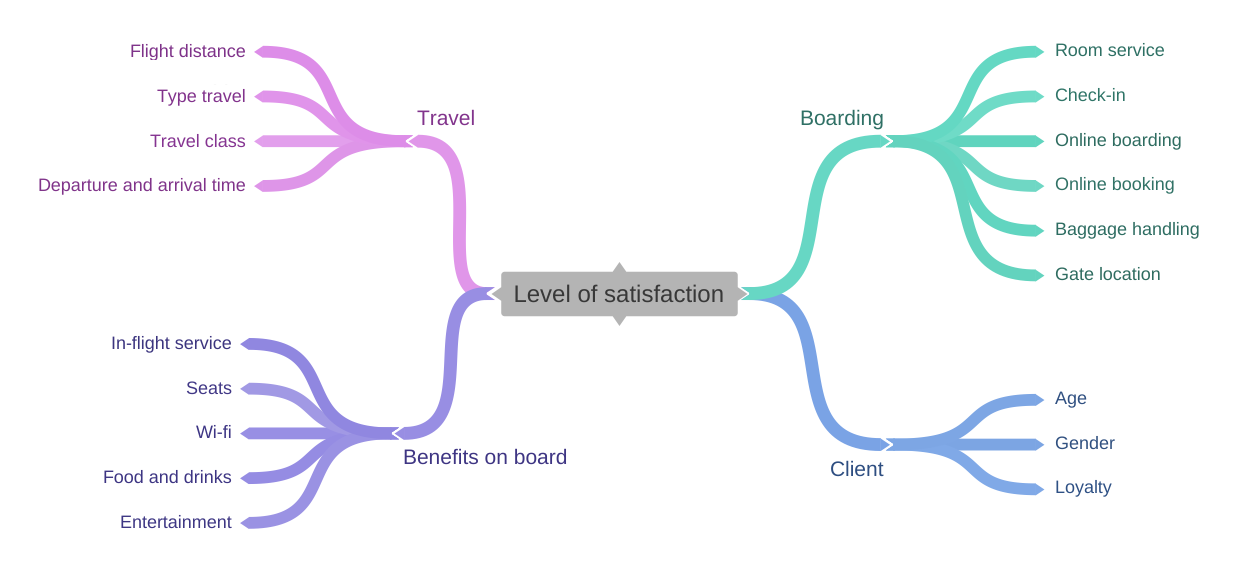

In [16]:
Image('/content/level_of_satisfaction.png')

##2.2 Creation of hypotheses

### 2.1.1 Travel

**1.** The longer the journey, the lower the customer satisfaction.


**2.** The better the type of trip, the greater the customer satisfaction.

 **3.** The better the class of travel, the better the customer satisfaction.

**4.** The shorter the delays, the greater the customer satisfaction.


### 2.1.2 Benefits on board

**1.** The better the in-flight service, the greater the customer satisfaction.

**2.** The better the quality of the seats, the greater the customer satisfaction.

 **3.** The better the Wi-fi, the greater the customer satisfaction.

**4.** The better the quality of food and drink, the greater the customer satisfaction.

**5.** The better the quality of entertainment, the greater the customer satisfaction.

### 2.1.3 Client

**1.** Loyal customers tend to be more satisfied.

**2.** The Male Gender is the most satisfied.

 **3.** The younger the age, the greater the customer satisfaction.

### 2.1.4 Boarding

**1.** The better the room service, the greater the customer satisfaction.

**2.** The better the Check-in quality, the greater the customer satisfaction.

 **3.** The better the quality of the online shipment, the greater the customer satisfaction.

 **4.** The better the handling of luggage, the greater the customer satisfaction.
 

 **5.** The better the quality of the online booking, the greater the customer satisfaction.

 **6.** The better the gate location, the greater the customer satisfaction.

##2.3 Final list of hypotheses

**H1-**.The greater the distance of the trip, the lower the customer satisfaction.

**H2-**.Personal travel customers are more satisfied.

**H3-**.Customers who use the Business class are more satisfied.

**H4-**.The shorter the delays, the better the customer satisfaction.

**H5-**.The better the in-flight service, the greater the customer satisfaction.

**H6-**.The better the quality of the seats, the greater the customer satisfaction.

**H7-**.The better the Wi-Fi, the better the customer satisfaction.

**H8-**.The better the quality of food and beverages, the better the customer satisfaction.

**H9-**. The greater the quality of entertainment, the greater the customer satisfaction.

**H10-**. Loyal customers tend to be more satisfied.

**H11-**.The Male Gender is the most satisfied.

**H12-**.The younger the age, the greater the customer satisfaction.

**H13-**The better the room service, the greater the customer satisfaction.

**H14-**The better the Check-in quality, the greater the customer satisfaction.

**H15-**The better the quality of online shipping, the greater the customer satisfaction.

**H16-**The better the baggage handling, the greater the customer satisfaction.

**H17-**The better the quality of the online booking, the greater the customer satisfaction.

**H18-**The better the gate location, the greater the customer satisfaction.

##2.4 Feature Engineering

In [17]:
#TotalScore
lista=[    'InflightWifiService','Departure/ArrivalTimeConvenient','EaseOfOnlineBooking',
           'GateLocation','FoodAndDrink','OnlineBoarding','SeatComfort',
           'InflightEntertainment','On-boardService','LegRoomService',
           'BaggageHandling','CheckinService','InflightService','Cleanliness']

df2[lista]=df2[lista].astype(int)
df2['TotalScore']=df2[lista].sum(axis=1)

#In-flightService
df2['In-flightService']=round((df2['On-boardService']+df2['InflightService'])/2,2)
df2[lista]=df2[lista].astype(str)

#SumOfDelays
df2['SumOfDelays']=df2['DepartureDelayInMinutes']+df2['ArrivalDelayInMinutes']

#3.0. VARIABLES FILTERING

In [18]:
df3=df2.copy()

##3.1. Columns Filtering

In [19]:
df3=df3.drop(['Unnamed: 0'],axis=1)

#4.0. EXPLORATORY DATA ANALYSIS

In [20]:
df4=df3.copy()

## 4.1 Univariate Analysis

In [21]:
#selecting numerical and categorical attributes
cat_attributes=df1.select_dtypes(include=['object'])
num_attributes=df2.select_dtypes(include=['float64','int64'])

###4.1.1. Response Variable

Text(0.5, 1.0, 'Number of people by satisfaction levels')

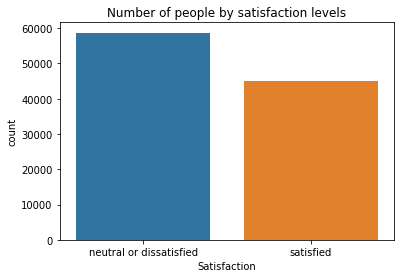

In [22]:
ax=sns.countplot(df4['Satisfaction'])
ax.set_title('Number of people by satisfaction levels')

###4.1.2. Numerical Variable

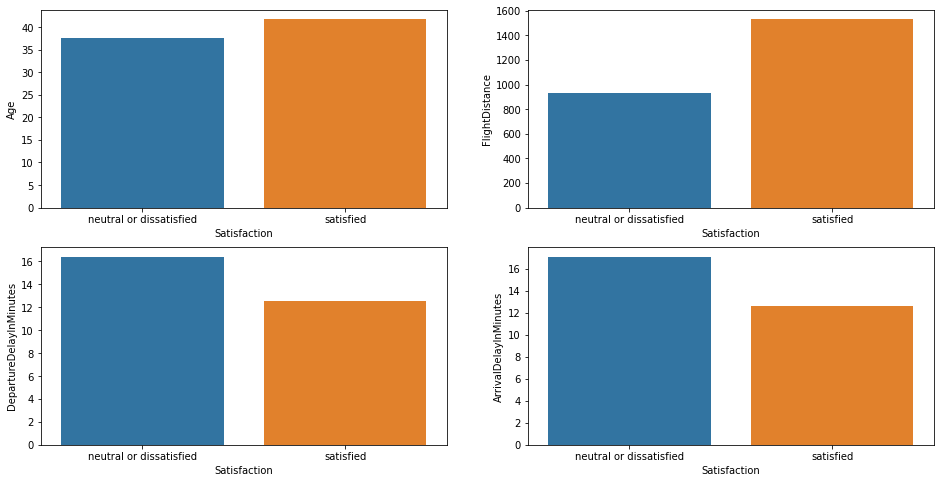

In [23]:
#Age
plt.subplot(2,2,1)
aux=df4[['Age','Satisfaction']].groupby(['Satisfaction']).mean().reset_index()
ax=sns.barplot(x='Satisfaction',y='Age',data=aux)
ax.figure.set_size_inches(16,8)

#FlightDistance
plt.subplot(2,2,2)
df4['FlightDistance']=df4['FlightDistance'].astype(int)
aux=df4[['FlightDistance','Satisfaction']].groupby(['Satisfaction']).mean().reset_index()
ax=sns.barplot(x='Satisfaction',y='FlightDistance',data=aux)

#DepartureDelayInMinutes
plt.subplot(2,2,3)
aux=df4[['DepartureDelayInMinutes','Satisfaction']].groupby(['Satisfaction']).mean().reset_index()
ax=sns.barplot(x='Satisfaction',y='DepartureDelayInMinutes',data=aux)

#ArrivalDelayInMinutes
plt.subplot(2,2,4)
aux=df4[['ArrivalDelayInMinutes','Satisfaction']].groupby(['Satisfaction']).mean().reset_index()
ax=sns.barplot(x='Satisfaction',y='ArrivalDelayInMinutes',data=aux)

###4.1.3. Categorical Variable

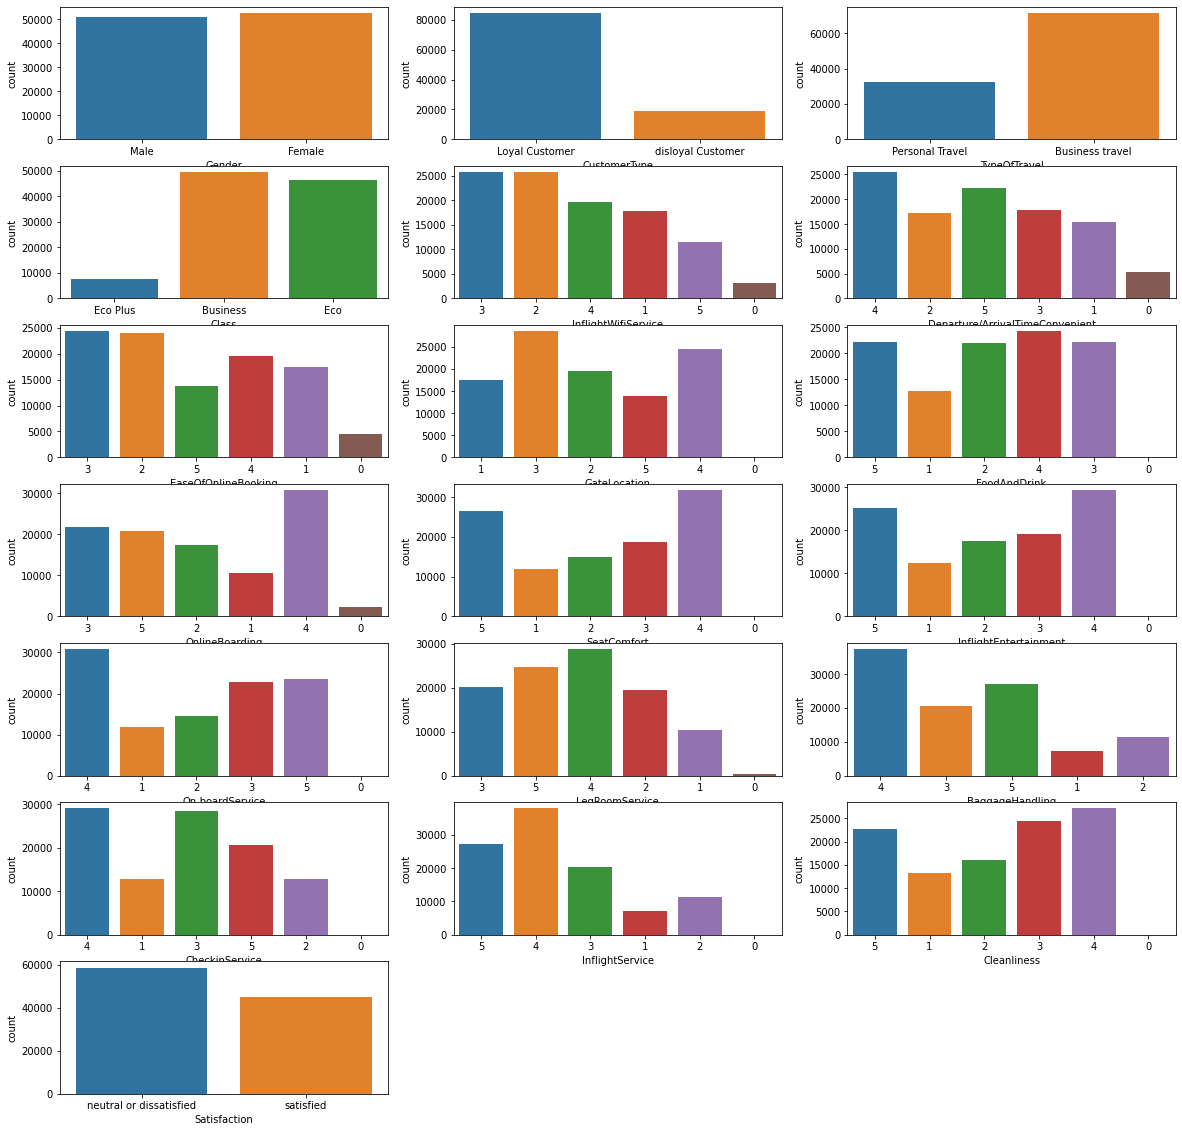

In [24]:
aux=cat_attributes.columns
for i in range(0,len(aux)):
  plt.subplot(7,3,i+1)
  a=aux[i]
  ax=sns.countplot(df4[a])
  ax.figure.set_size_inches(20,20)

## 4.2 Bivariate Analysis

Correlation:


*   0,10 - 0,29 (low)
*   0,30 - 0,49 (medium)
*   0,50 - 1    (high)

### ***H1***. The greater the distance of the trip, the lower the customer satisfaction.
  (FALSE-Medium)

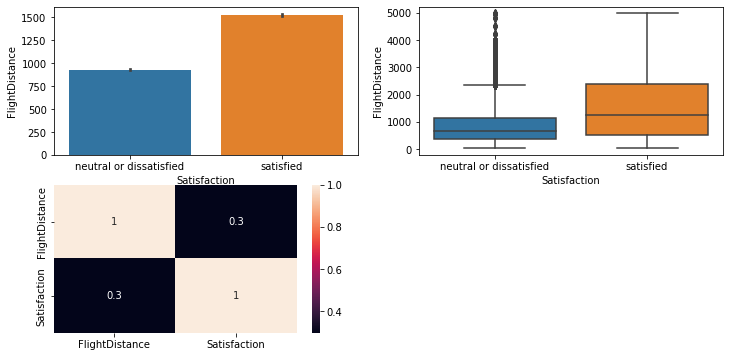

In [25]:
plot_numeric_categorical('FlightDistance','Satisfaction',df4)

#### The flight distance of satisfied customers is 24% greater. 

### ***H2***. Personal travel customers are more satisfied. (FALSE-High)


Text(0.5, 1.0, 'Dissatisfied')

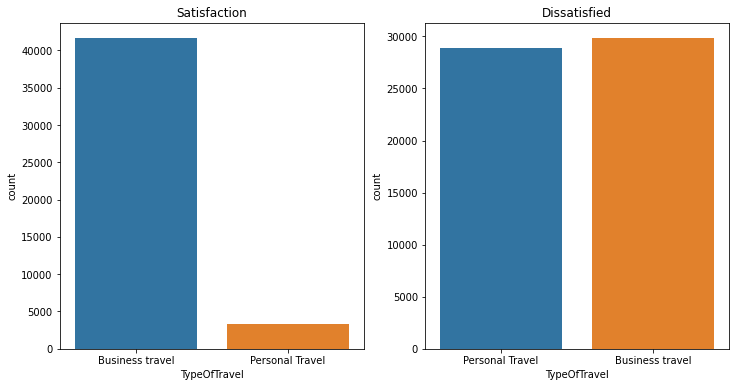

In [26]:
plt.subplot(1,2,1)
aux=df4[df4['Satisfaction']=='satisfied']
ax=sns.countplot(aux['TypeOfTravel'])
ax.set_title('Satisfaction')
ax.figure.set_size_inches(12,6)

plt.subplot(1,2,2)
aux=df4[df4['Satisfaction']=='neutral or dissatisfied']
ax=sns.countplot(aux['TypeOfTravel'])
ax.set_title('Dissatisfied')

### ***H3***. Customers who use the Business class are more satisfied.
(TRUE-High)

Satisfaction Rate by classes: 
Eco Plus: 24.58 %
Business: 69.43 %
Eco:      18.61 %



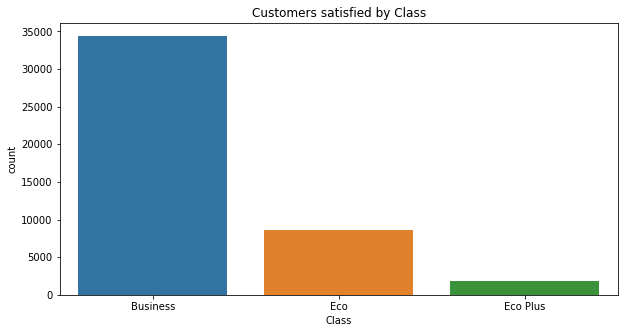

In [27]:
aux=df4[df4['Satisfaction']=='satisfied']
ax=sns.countplot(aux['Class'])
ax.set_title('Customers satisfied by Class')
ax.figure.set_size_inches(10,5)

lista=df4['Class'].unique()
lista2=[]
for i in range (0,3):
  total=df4[df4['Class']==lista[i]].shape[0]
  satisfeitos=df4[(df4['Class']==lista[i]) & (df4['Satisfaction']=='satisfied')].shape[0]
  percentual=(satisfeitos*100)/total
  lista2.append(percentual)

print('Satisfaction Rate by classes: ')
print('Eco Plus: {} %'.format(round(lista2[0],2)))
print('Business: {} %'.format(round(lista2[1],2)))
print('Eco:      {} %'.format(round(lista2[2],2)))
print()

### ***H4***. The shorter the delays, the better the customer satisfaction.(TRUE-Low) 


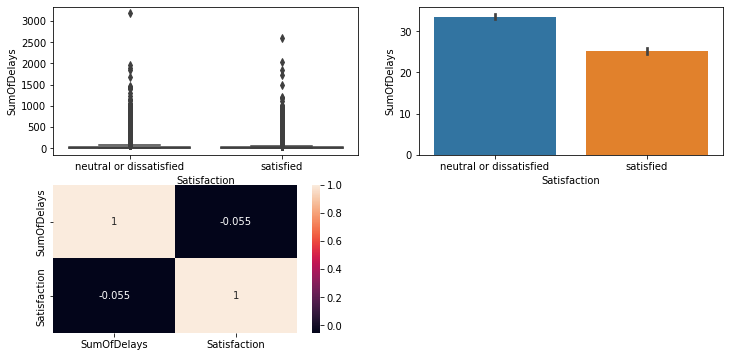

In [28]:
plt.subplot(2,2,1)
ax=sns.boxplot(x='Satisfaction',y='SumOfDelays',data=df4)
ax.figure.set_size_inches(12,6)

plt.subplot(2,2,2)
ax=sns.barplot(x='Satisfaction',y='SumOfDelays',data=df4)

plt.subplot(2,2,3)
ax=numeric_categorical('SumOfDelays','Satisfaction',df4)

### ***H5***. The better the in-flight service, the greater the customer satisfaction.(TRUE-Medium)

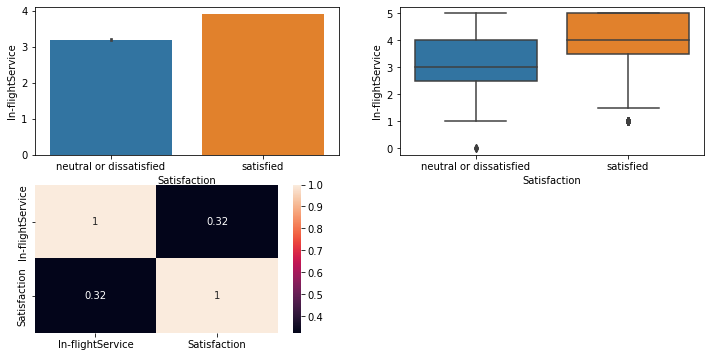

In [29]:
plot_numeric_categorical('In-flightService','Satisfaction',df4)

### ***H6***. The better the quality of the seats, the greater the customer satisfaction.(TRUE-Medium)

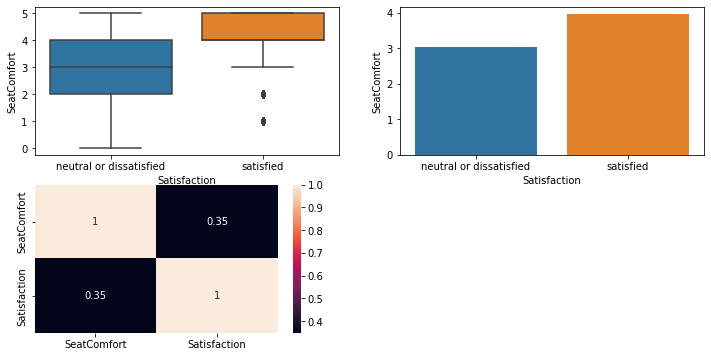

In [30]:
plot_categorical_categorical('SeatComfort','Satisfaction',df4)

### ***H7***. The better the Wi-Fi, the better the customer satisfaction.(TRUE-Low)

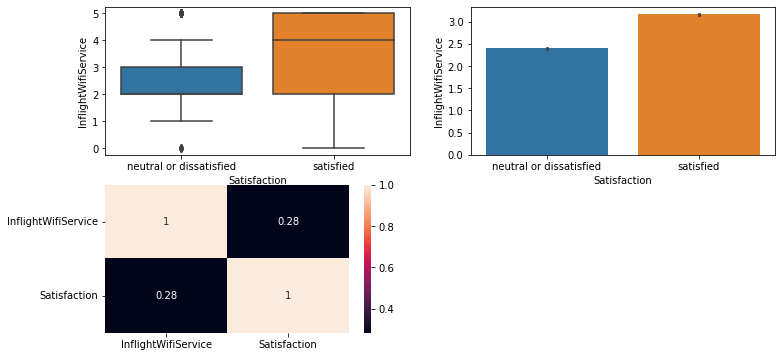

In [31]:
plot_categorical_categorical('InflightWifiService','Satisfaction',df4)

### ***H8***. The better the quality of food and beverages, the better the customer satisfaction.(TRUE-Low)

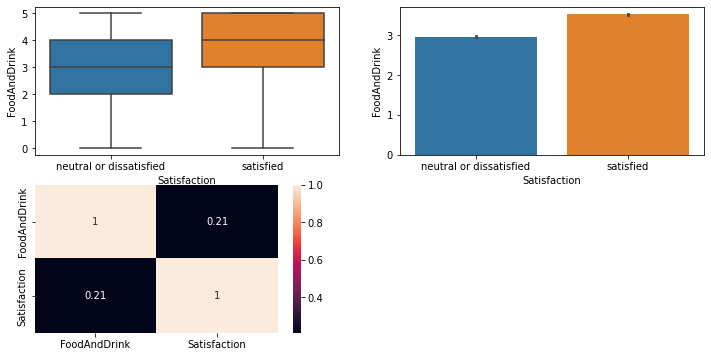

In [32]:
plot_categorical_categorical('FoodAndDrink','Satisfaction',df4)

### ***H9***. The greater the quality of entertainment, the greater the customer satisfaction.(TRUE-Medium)

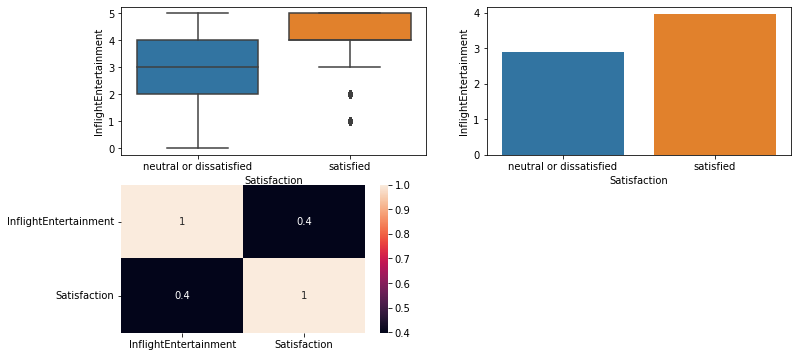

In [33]:
plot_categorical_categorical('InflightEntertainment','Satisfaction',df4)

### ***H10***. Loyal customers tend to be more satisfied.(FALSE-Low)

Text(0.5, 1.0, 'Loyal customer satisfaction level , correlation : 0.19')

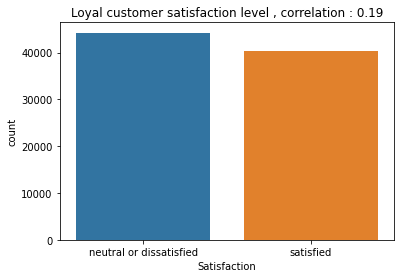

In [34]:
c=round(cramer_v(df4['CustomerType'],df4['Satisfaction']),2)
aux=df4[df4['CustomerType']=='Loyal Customer']
ax=sns.countplot(aux['Satisfaction'])
ax.set_title('Loyal customer satisfaction level , correlation : {}'.format(c))

### ***H11***.The Male Gender is the most satisfied.(FALSE-Low)

Text(0.5, 1.0, 'Customers Satisfied by Gender, correlation: 0.01')

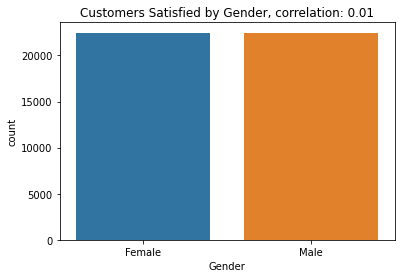

In [35]:
c=round(cramer_v(df4['Gender'],df4['Satisfaction']),2)
satisfeitos=df4[df4['Satisfaction']=='satisfied']
insatisfeitos=df4[df4['Satisfaction']=='neutral or dissatisfied']
ax=sns.countplot(satisfeitos['Gender'])
ax.set_title('Customers Satisfied by Gender, correlation: {}'.format(c))

### ***H12***. The younger the age, the greater the customer satisfaction.(FALSE-Low)

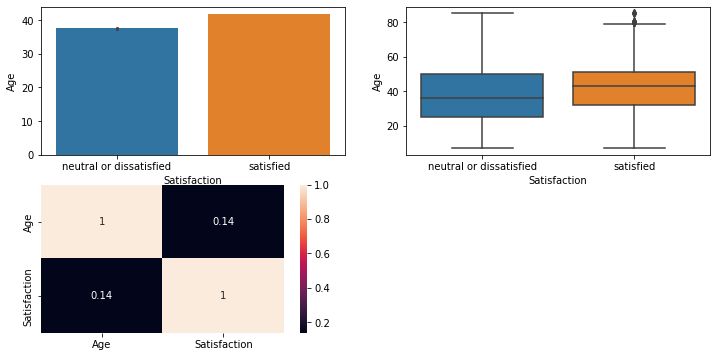

In [36]:
plot_numeric_categorical('Age','Satisfaction',df4)

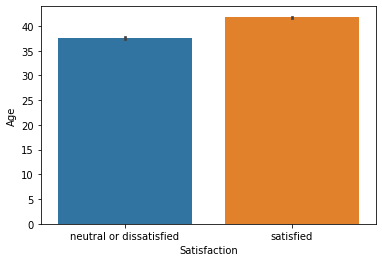

In [37]:
ax=sns.barplot(x='Satisfaction',y='Age',data=df4)

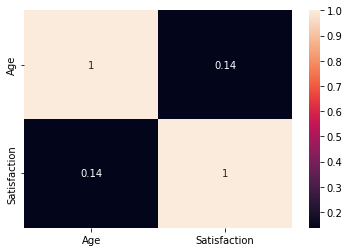

In [38]:
numeric_categorical('Age','Satisfaction',df4)

### ***H13***. The better the room service, the greater the customer satisfaction..(TRUE-Medium)

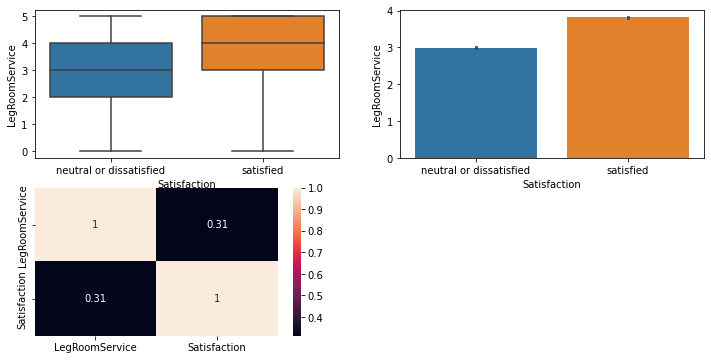

In [39]:
plot_categorical_categorical('LegRoomService','Satisfaction',df4)

### ***H14***. The better the Check-in quality, the greater the customer satisfaction.(TRUE-Low)

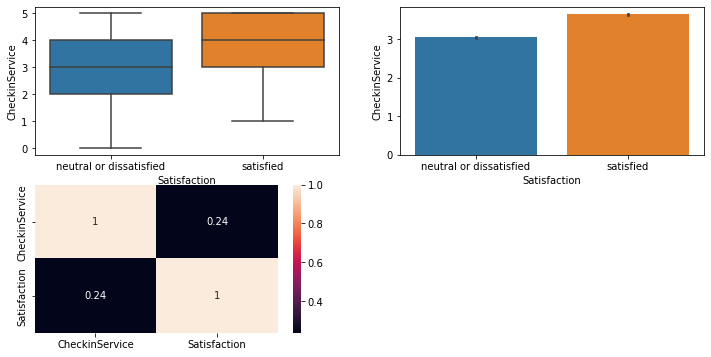

In [40]:
plot_categorical_categorical('CheckinService','Satisfaction',df4)

### ***H15***. The better the quality of online shipping, the greater the customer satisfaction.(TRUE-High)

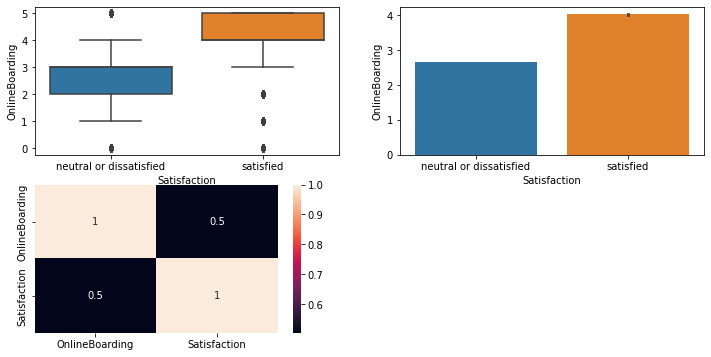

In [41]:
plot_categorical_categorical('OnlineBoarding','Satisfaction',df4)

### ***H16***. The better the baggage handling, the greater the customer satisfaction.(TRUE-Low)

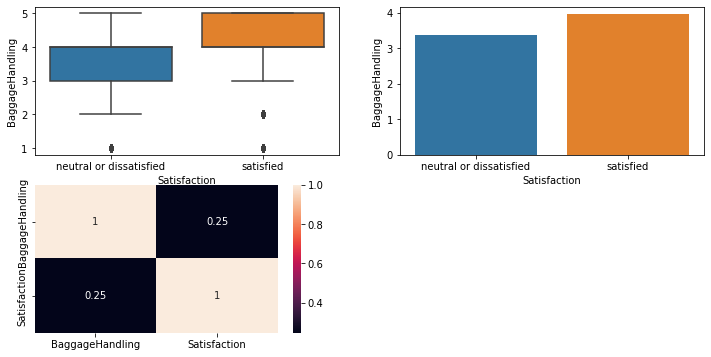

In [42]:
plot_categorical_categorical('BaggageHandling','Satisfaction',df4)

### ***H17***. The better the quality of the online booking, the greater the customer satisfaction.
 (TRUE-Low)

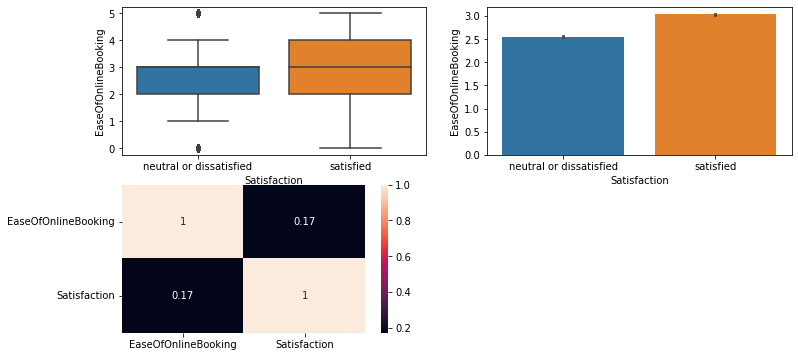

In [43]:
plot_categorical_categorical('EaseOfOnlineBooking','Satisfaction',df4)

### ***H18***. The better the gate location, the greater the customer satisfaction. (FALSE-Baixa)

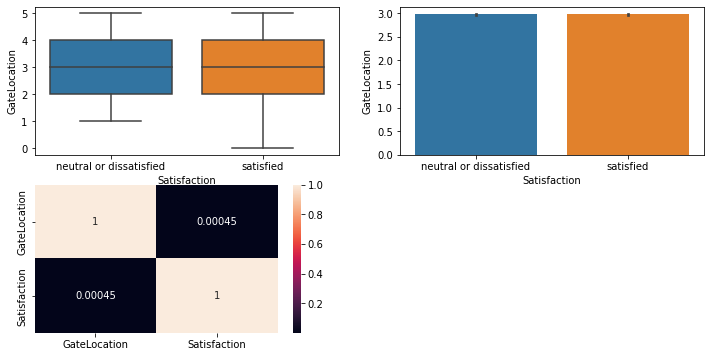

In [44]:
plot_categorical_categorical('GateLocation','Satisfaction',df4)

### 4.2.1 Summary of hypotheses

In [45]:
tab=[['Hypotheses',  'Status',     'Relevance'],
     ['H1',          'False',      'Medium'],
     ['H2',          'False',      'High'],
     ['H3',          'True',       'High'],
     ['H4',          'True',       'Low'],
     ['H5',          'True',       'Medium'],
     ['H6',          'True',       'Medium'],
     ['H7',          'True',       'Low'],
     ['H8',          'True',       'Low'],
     ['H9',          'True',       'Medium'],
     ['H10',         'False',      'Low'],
     ['H11',         'False',      'Low'],
     ['H12',         'False',      'Low'],
     ['H13',         'True',       'Medium'],
     ['H14',         'True',       'Low'],
     ['H15',         'True',       'High'],
     ['H16',         'True',       'Low'],
     ['H17',         'True',       'Low'],
     ['H18',         'False',      'Low']]
     

print(tabulate(tab,headers='firstrow'))

Hypotheses    Status    Relevance
------------  --------  -----------
H1            False     Medium
H2            False     High
H3            True      High
H4            True      Low
H5            True      Medium
H6            True      Medium
H7            True      Low
H8            True      Low
H9            True      Medium
H10           False     Low
H11           False     Low
H12           False     Low
H13           True      Medium
H14           True      Low
H15           True      High
H16           True      Low
H17           True      Low
H18           False     Low


## 4.3 Multivariate Analysis

###4.3.1. Numerical Atributes

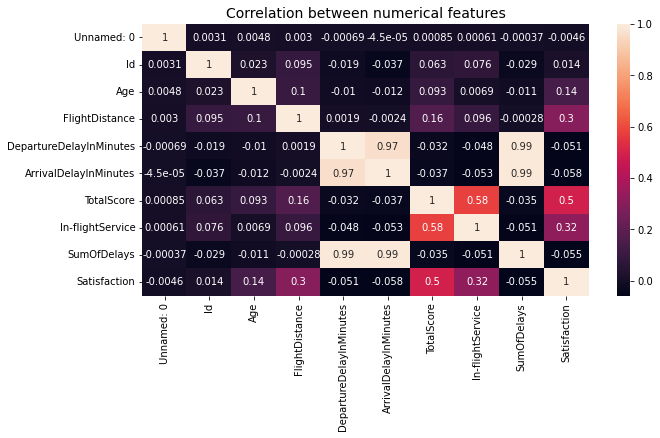

In [46]:
num_attributes['Satisfaction']=df4['Satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)
correlation_numeric(num_attributes,num_attributes)

###4.3.2. Categorical Atributes

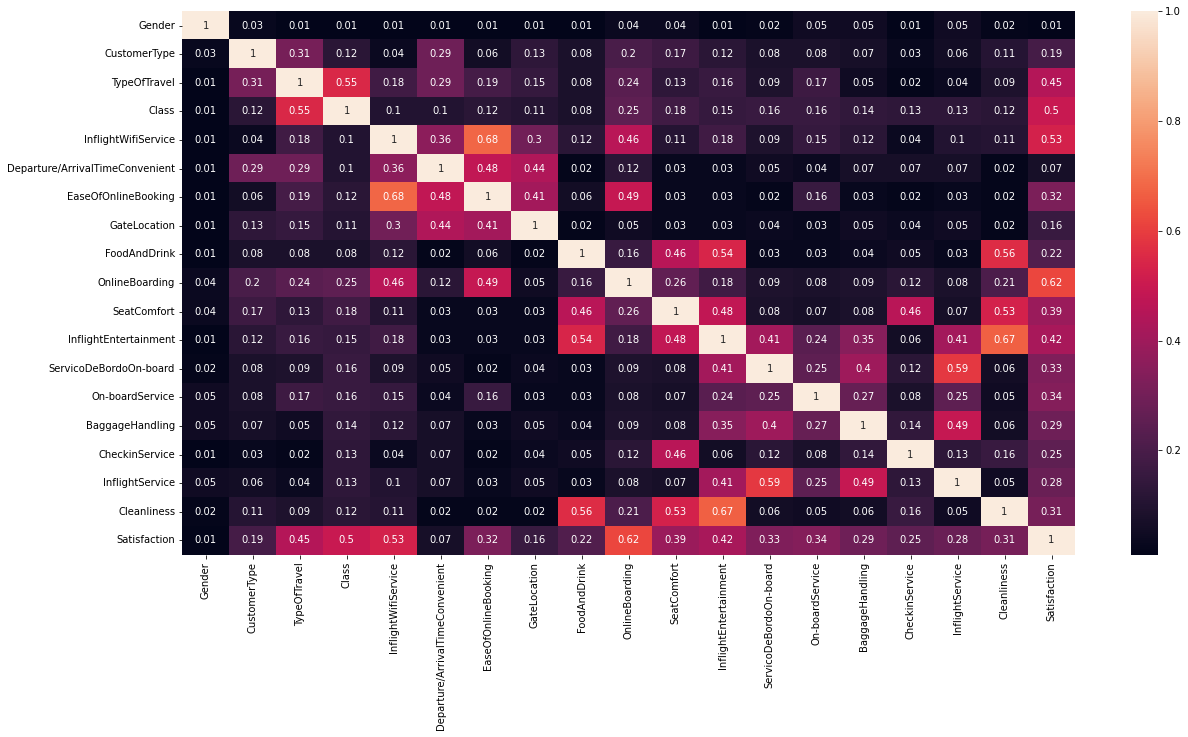

In [47]:
a=df4.select_dtypes(include='object')

columns=a.columns

lista2=[]
for i2 in range(0,len(a.columns)):
  lista=[]
  for i in range(0,len(a.columns)):    
    lista.append(round(cramer_v(a[columns[i2]],a[columns[i]]),2))  
  lista2.append(lista)


d=pd.DataFrame({  'Gender':                           lista2[0],
                  'CustomerType':                     lista2[1],
                  'TypeOfTravel':                     lista2[2],
                  'Class':                            lista2[3],
                  'InflightWifiService':              lista2[4],
                  'Departure/ArrivalTimeConvenient':  lista2[5],
                  'EaseOfOnlineBooking':              lista2[6],
                  'GateLocation':                     lista2[7],
                  'FoodAndDrink':                     lista2[8],
                  'OnlineBoarding':                   lista2[9],
                  'SeatComfort':                      lista2[10],
                  'InflightEntertainment':            lista2[11],
                  'ServicoDeBordoOn-board':           lista2[12],
                  'On-boardService':                  lista2[13],
                  'BaggageHandling':                  lista2[14],
                  'CheckinService':                   lista2[15],
                  'InflightService':                  lista2[16],
                  'Cleanliness':                      lista2[17],
                  'Satisfaction':                     lista2[18]
             })

d=d.set_index(d.columns)

ax=sns.heatmap(d,annot=True)
ax.figure.set_size_inches(20,10)

##4.4 Report

### Which features best explain the phenomenon ?

*   OnlineBoarding
*   Class
*   TypeOfTravel
*   InflightEntertainment
*   SeatComfort








### Which features self-correlate?



*   Cleanliness and InflightEntertainment (0,67)
*   On-boardService and InflightService (0,59)
*   Cleanliness and FoodAndDrink (0,56)
*   OnlineBoarding and EaseOfOnlineBooking (0,49)












###What is the average score of the top three features of satisfied customers ?

In [48]:
aux=df4.copy()
aux=aux[aux['Satisfaction']=='satisfied']
a=['OnlineBoarding','InflightEntertainment','SeatComfort']
aux[a]=aux[a].astype(int)

print('OnlineBoarding:        {}'.format(round(aux['OnlineBoarding'].mean(),2)))
print('InflightEntertainment: {}'.format(round(aux['InflightEntertainment'].mean(),2)))
print('SeatComfort:           {}'.format(round(aux['SeatComfort'].mean(),2)))

OnlineBoarding:        4.03
InflightEntertainment: 3.97
SeatComfort:           3.97


#5.0. DATA PREPARATION

In [49]:
df5=df4.copy()

##5.1. Rescaling

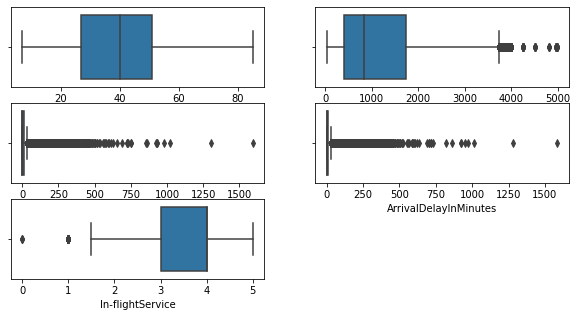

In [50]:
num_attributes['In-flightService']=df5['In-flightService'].copy()

plt.subplot(3,2,1)
ax=sns.boxplot(num_attributes['Age'])
ax.figure.set_size_inches(10,5)

plt.subplot(3,2,2)
ax=sns.boxplot(num_attributes['FlightDistance'])

plt.subplot(3,2,3)
ax=sns.boxplot(num_attributes['DepartureDelayInMinutes'])

plt.subplot(3,2,4)
ax=sns.boxplot(num_attributes['ArrivalDelayInMinutes'])

plt.subplot(3,2,5)
ax=sns.boxplot(num_attributes['In-flightService'])

In [51]:
rs=RobustScaler()
mms=MinMaxScaler()

#RobustScaler
#DepartureDelayInMinutes
df5['DepartureDelayInMinutes']=rs.fit_transform(df5[['DepartureDelayInMinutes']].values)

#ArrivalDelayInMinutes
df5['ArrivalDelayInMinutes']=rs.fit_transform(df5[['ArrivalDelayInMinutes']].values)

#SumOfDelays
df5['SumOfDelays']=rs.fit_transform(df5[['SumOfDelays']].values)

#MinMaxScaler
#Age
df5['Age']=mms.fit_transform(df5[['Age']].values)
pickle.dump(mms,open('/content/Age_scaler.pkl','wb'))

#FlightDistance
df5['FlightDistance']=mms.fit_transform(df5[['FlightDistance']].values)
pickle.dump(mms,open('/content/FlightDistance_scaler.pkl','wb'))

#TotalScore
df5['TotalScore']=mms.fit_transform(df5[['TotalScore']].values)

#In-flightService
df5['In-flightService']=mms.fit_transform(df5[['In-flightService']].values)
pickle.dump(mms,open('/content/In-flightService_scaler.pkl','wb'))

## 5.2. Transformation

###5.2.1. Encoding

In [52]:
#Ordinal Encoding
r=0.166
assortment_dict={'0':0*r,'1':1*r,'2':2*r,'3':3*r,'4':4*r,'5':5*r}

#InflightWifiService    
df5['InflightWifiService']=df5['InflightWifiService'].map(assortment_dict)

#Departure/ArrivalTimeConvenient  
df5['Departure/ArrivalTimeConvenient']=df5['Departure/ArrivalTimeConvenient'].map(assortment_dict) 

#EaseOfOnlineBooking  
df5['EaseOfOnlineBooking']=df5['EaseOfOnlineBooking'].map(assortment_dict) 

#GateLocation
df5['GateLocation']=df5['GateLocation'].map(assortment_dict)

#FoodAndDrink  
df5['FoodAndDrink']=df5['FoodAndDrink'].map(assortment_dict)

#OnlineBoarding 
df5['OnlineBoarding']=df5['OnlineBoarding'].map(assortment_dict) 

#SeatComfort 
df5['SeatComfort']=df5['SeatComfort'].map(assortment_dict)

#InflightEntertainment 
df5['InflightEntertainment']=df5['InflightEntertainment'].map(assortment_dict) 

#On-boardService
df5['On-boardService']=df5['On-boardService'].map(assortment_dict)  

#LegRoomService 
df5['LegRoomService']=df5['LegRoomService'].map(assortment_dict) 

#CheckinService
df5['CheckinService']=df5['CheckinService'].map(assortment_dict) 

#BaggageHandling
df5['BaggageHandling']=df5['BaggageHandling'].map(assortment_dict)

#InflightService
df5['InflightService']=df5['InflightService'].map(assortment_dict)  

#Cleanliness  
df5['Cleanliness']=df5['Cleanliness'].map(assortment_dict)  


#labelEncoder
le=LabelEncoder()
#Gender
df5['Gender']=le.fit_transform(df5['Gender'])

#CustomerType
df5['CustomerType']=le.fit_transform(df5['CustomerType'])
pickle.dump(le,open('/content/CustomerType_scaler.pkl','wb'))

#TypeOfTravel
df5['TypeOfTravel']=le.fit_transform(df5['TypeOfTravel'])
pickle.dump(le,open('/content/TypeOfTravel_scaler.pkl','wb'))

#Class
df5['Class']=le.fit_transform(df5['Class'])
pickle.dump(le,open('/content/Class_scaler.pkl','wb'))

In [53]:
#Satisfaction
df5['Satisfaction']=df5['Satisfaction'].apply(lambda x: 1 if x=='satisfied' else 0)

#6.0. FEATURE SELECTION

In [54]:
df6=df5.copy()

##6.1. Split dataframe into training and test dataset.

In [55]:
#train and test
y=df6['Satisfaction']
x=df6.drop(['Satisfaction','Id'],axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2811)

##6.2. Boruta as feature selector


In [56]:
boruta=boruta(x_train,y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	10


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	0
Rejected: 	10


###6.2.1. Best Features

In [57]:
best_features(boruta,x_train)

['CustomerType',
 'Age',
 'TypeOfTravel',
 'Class',
 'FlightDistance',
 'InflightWifiService',
 'GateLocation',
 'OnlineBoarding',
 'SeatComfort',
 'InflightEntertainment',
 'BaggageHandling',
 'CheckinService',
 'InflightService',
 'Cleanliness',
 'In-flightService']

##6.3. Manual Feature selection


In [58]:
cols_selected_boruta=['CustomerType','Age','TypeOfTravel','Class',
                      'FlightDistance','InflightWifiService','GateLocation',
                      'OnlineBoarding','SeatComfort','InflightEntertainment',
                      'BaggageHandling','CheckinService','InflightService',
                      'Cleanliness','In-flightService']

#Columns to add
feat_to_add=['Satisfaction']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#7.0. MACHINE LEARNING MODELLING

In [59]:
#activating selected columns
x_train_select=x_train[cols_selected_boruta]
x_test_select=x_test[cols_selected_boruta]

#NearMiss
nr=NearMiss()
x_train_nm,y_train_nm=nr.fit_sample(x_train_select,y_train)
x_test_nm,y_test_nm=nr.fit_sample(x_test_select,y_test)

x_train=pd.DataFrame(data=x_train_nm,columns=x_train_select.columns)
x_test=pd.DataFrame(data=x_test_nm,columns=x_test_select.columns)

y_train=pd.DataFrame(data=y_train_nm,columns=['Satisfaction'])
y_test=pd.DataFrame(data=y_test_nm,columns=['Satisfaction'])

##7.1. Baseline

In [60]:
#Prediction
yhat_rendom=np.ones(len(y_test))

#Performance
baseline_result=model_performance(y_test,yhat_rendom,'Baseline')
baseline_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,Baseline,0.500,1.000,0.667,0.500


##7.2. ExtraTreeClassifier

In [61]:
#Model
etc = ExtraTreeClassifier(random_state=0)
etc_train=etc.fit(x_train,y_train)

#Prediction
yhat_etc=etc_train.predict(x_test)

#Performance
etc_result=model_performance(y_test,yhat_etc,'ExtraTreeClassifier')
etc_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,ExtraTreeClassifier,0.909,0.908,0.909,0.909


###7.2.1 ExtraTreeClassifier cross validation

In [62]:
etc_result_cv=cross_validation(5,x_train,y_train,'ExtraTreeClassifier',etc)
etc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,ExtraTreeClassifier,0.91+/-0.0,0.91+/-0.0,0.91+/-0.0,0.91+/-0.0


##7.3. Random Forest Classifier

In [63]:
#Model
rfc=RandomForestClassifier(max_depth=2, random_state=0)
rfc_train=rfc.fit(x_train,y_train)

#Predict
yhat_rfc=rfc_train.predict(x_test)

#Performance
rfc_result=model_performance(y_test,yhat_rfc,'RandomForestClassifier')
rfc_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,RandomForestClassifier,0.873,0.823,0.848,0.852


###7.3.1 Random Forest Classifier cross validation

In [64]:
rfc_result_cv=cross_validation(5,x_train,y_train,'RandomForestClassifier',rfc)
rfc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,RandomForestClassifier,0.87+/-0.0,0.82+/-0.0,0.85+/-0.0,0.85+/-0.0


##7.4. Logistic Regression

In [65]:
#Model
lr= LogisticRegression(random_state=0)
lr_train=lr.fit(x_train,y_train)

#Predict
yhat_lr=lr_train.predict(x_test)

#Performance
lr_result=model_performance(y_test,yhat_lr,'Logistic Regression')
lr_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,Logistic Regression,0.861,0.840,0.850,0.852


###7.4.1 Logistic Regression cross validation

In [66]:
lr_result_cv=cross_validation(5,x_train,y_train,'Logistic Regression',lr)
lr_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,Logistic Regression,0.86+/-0.0,0.84+/-0.0,0.85+/-0.0,0.85+/-0.0


##7.5. KNeighbors Classifier 


In [67]:
#Model
knn = KNeighborsClassifier(n_neighbors=5)
knn_train=knn.fit(x_train,y_train)

#Prediction
yhat_knn=knn_train.predict(x_test)

#Performance
knn_result=model_performance(y_test,yhat_knn,'KNeighbors Classifier')
knn_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,KNeighbors Classifier,0.960,0.890,0.923,0.926


###7.5.1 KNeighbors Classifier cross validation

In [68]:
knn_result_cv=cross_validation(5,x_train,y_train,'KNeighbors Classifier',knn)
knn_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,KNeighbors Classifier,0.96+/-0.0,0.88+/-0.0,0.92+/-0.0,0.92+/-0.0


##7.6. Naive Bayes Gaussian

In [69]:
#Model
gau = GaussianNB()
gau_train=gau.fit(x_train,y_train)

#Prediction
yhat_gau=gau_train.predict(x_test)

#Performance
gau_result=model_performance(y_test,yhat_gau,'Naive Bayes Gaussian')
gau_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,Naive Bayes Gaussian,0.873,0.808,0.839,0.845


###7.6.1 Naive Bayes Gaussian cross validation

In [70]:
gau_result_cv=cross_validation(5,x_train,y_train,'Naive Bayes Gaussian',gau)
gau_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,Naive Bayes Gaussian,0.88+/-0.0,0.81+/-0.0,0.84+/-0.0,0.85+/-0.0


##7.7. Naive Bayes Bernoulli

In [71]:
#Model
ber= BernoulliNB()
ber_train=ber.fit(x_train,y_train)

#Prediction
yhat_ber=ber_train.predict(x_test)

#Performance
ber_result=model_performance(y_test,yhat_ber,'Naive Bayes Bernoulli')
ber_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,Naive Bayes Bernoulli,0.752,0.788,0.770,0.764


###7.7.1 Naive Bayes Bernoulli cross validation

In [72]:
ber_result_cv=cross_validation(5,x_train,y_train,'Naive Bayes Bernoulli',ber)
ber_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,Naive Bayes Bernoulli,0.74+/-0.0,0.78+/-0.0,0.76+/-0.0,0.75+/-0.0


##7.8. DecisionTreeClassifier

In [73]:
#Model
dtc= DecisionTreeClassifier(random_state=0)
dtc_train=dtc.fit(x_train,y_train)

#Prediction
yhat_dtc=dtc_train.predict(x_test)

#Performance
dtc_result=model_performance(y_test,yhat_dtc,'DecisionTreeClassifier')
dtc_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,DecisionTreeClassifier,0.937,0.938,0.938,0.938


###7.8.1 DecisionTreeClassifier cross validation

In [74]:
dtc_result_cv=cross_validation(5,x_train,y_train,'DecisionTreeClassifier',dtc)
dtc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,DecisionTreeClassifier,0.94+/-0.0,0.94+/-0.0,0.94+/-0.0,0.94+/-0.0


##7.9. XGBoostClassifier

In [75]:
#Model
xgbc= xgb.XGBClassifier()
xgbc_train=xgbc.fit(x_train,y_train)

#Prediction
yhat_xgbc=xgbc_train.predict(x_test)

#Performance
xgbc_result=model_performance(y_test,yhat_xgbc,'XGBClassifier')
xgbc_result

,Model Name,Precision,Recall,F1Score,Accuracy
0,XGBClassifier,0.943,0.917,0.930,0.931


###7.9.1 XGBoostClassifier cross validation

In [76]:
xgbc_result_cv=cross_validation(5,x_train,y_train,'XGBClassifier',xgbc)
xgbc_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,XGBClassifier,0.94+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0


##7.10. Compare Model's Performance

###7.10.1. Single Performance


In [77]:
modelling_results=pd.concat([etc_result,rfc_result,lr_result,knn_result,gau_result,ber_result,dtc_result],axis=0)
modelling_results.sort_values('F1Score',ascending=False)

,Model Name,Precision,Recall,F1Score,Accuracy
0,DecisionTreeClassifier,0.937,0.938,0.938,0.938
0,KNeighbors Classifier,0.960,0.890,0.923,0.926
0,ExtraTreeClassifier,0.909,0.908,0.909,0.909
0,Logistic Regression,0.861,0.840,0.850,0.852
0,RandomForestClassifier,0.873,0.823,0.848,0.852
0,Naive Bayes Gaussian,0.873,0.808,0.839,0.845
0,Naive Bayes Bernoulli,0.752,0.788,0.770,0.764


###7.10.2. Real Performance - Cross Validation


In [78]:
modelling_results_cv=pd.concat([etc_result_cv,rfc_result_cv,lr_result_cv,knn_result_cv,gau_result_cv,ber_result_cv,dtc_result_cv],axis=0)
modelling_results_cv=modelling_results_cv[['ModelName','PrecisionCV','F1ScoreCV','RecallCV','AccuracyCV']]
modelling_results_cv.sort_values('F1ScoreCV',ascending=False)

,ModelName,PrecisionCV,F1ScoreCV,RecallCV,AccuracyCV
0,DecisionTreeClassifier,0.94+/-0.0,0.94+/-0.0,0.94+/-0.0,0.94+/-0.0
0,KNeighbors Classifier,0.96+/-0.0,0.92+/-0.0,0.88+/-0.0,0.92+/-0.0
0,ExtraTreeClassifier,0.91+/-0.0,0.91+/-0.0,0.91+/-0.0,0.91+/-0.0
0,RandomForestClassifier,0.87+/-0.0,0.85+/-0.0,0.82+/-0.0,0.85+/-0.0
0,Logistic Regression,0.86+/-0.0,0.85+/-0.0,0.84+/-0.0,0.85+/-0.0
0,Naive Bayes Gaussian,0.88+/-0.0,0.84+/-0.0,0.81+/-0.0,0.85+/-0.0
0,Naive Bayes Bernoulli,0.74+/-0.0,0.76+/-0.0,0.78+/-0.0,0.75+/-0.0


#8.0. HYPERPARAMETER FINE TUNING

##8.1.Random Search

In [79]:
#Params
param= {      'max_features':      ['auto', 'sqrt'],
              'min_samples_leaf':  [1, 2, 4, 6, 8, 10] ,
              'min_samples_split': [2, 5, 10, 15, 20],
              'max_depth' :        [int (x) for x in np.linspace (10, 110, num = 11)]}
        


MAX_EVAL=10

final_results=pd.DataFrame()

for i in range (MAX_EVAL):

  #Choose values for parameters randomly
  hp={k:random.sample(v,1)[0] for k,v in param.items()}
  print(hp)

  #Model
  model_dtc=DecisionTreeClassifier(        random_state=0 ,                             
                                        max_features=       hp['max_features'],
                                        min_samples_leaf=   hp['min_samples_leaf'],
                                        min_samples_split=  hp['min_samples_split'],
                                        max_depth=          hp['max_depth']
                                )            
                            
  
  #Performance
  results=cross_validation(5,x_train,y_train,'DecisionTreeClassifier',model_dtc)
  final_results=pd.concat([final_results,results])
final_results

{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 20, 'max_depth': 40}
{'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'max_depth': 80}
{'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 10, 'max_depth': 70}
{'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'max_depth': 20}
{'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_depth': 40}
{'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': 100}
{'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 5, 'max_depth': 10}
{'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 15, 'max_depth': 50}
{'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 2, 'max_depth': 90}
{'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_depth': 20}


,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,DecisionTreeClassifier,0.94+/-0.0,0.89+/-0.0,0.91+/-0.0,0.92+/-0.0
0,DecisionTreeClassifier,0.94+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0
0,DecisionTreeClassifier,0.95+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0
0,DecisionTreeClassifier,0.94+/-0.0,0.92+/-0.0,0.93+/-0.0,0.93+/-0.0
0,DecisionTreeClassifier,0.95+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0
0,DecisionTreeClassifier,0.94+/-0.0,0.89+/-0.0,0.91+/-0.0,0.92+/-0.0
0,DecisionTreeClassifier,0.9+/-0.0,0.91+/-0.0,0.9+/-0.0,0.9+/-0.0
0,DecisionTreeClassifier,0.94+/-0.0,0.9+/-0.0,0.92+/-0.0,0.92+/-0.0
0,DecisionTreeClassifier,0.95+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0
0,DecisionTreeClassifier,0.94+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0


##8.2.Final Model

In [80]:
#Params tuned
params_tuned={'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 20, 'max_depth': 60}


#Model
model_dtc_tuned=DecisionTreeClassifier( random_state=0 ,                             
                                        max_features=      params_tuned['max_features'],
                                        min_samples_leaf=  params_tuned['min_samples_leaf'],
                                        min_samples_split= params_tuned['min_samples_split'],
                                        max_depth=         params_tuned['max_depth']) 

model_dtc_tuned_train=model_dtc_tuned.fit(x_train,y_train)

#Prediction
yhat_model_dtc=model_dtc_tuned_train.predict(x_test)

#Performance
etr_result_cv=cross_validation(5,x_train,y_train,'DecisionTreeClassifier',model_dtc_tuned)
etr_result_cv

,ModelName,PrecisionCV,RecallCV,F1ScoreCV,AccuracyCV
0,DecisionTreeClassifier,0.94+/-0.0,0.91+/-0.0,0.93+/-0.0,0.93+/-0.0


In [81]:
#Save trained model
pickle.dump(model_dtc_tuned_train,open('/content/model_dtc_tuned_train.pkl','wb'))

#9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

##9.1.Machine Learning Performance

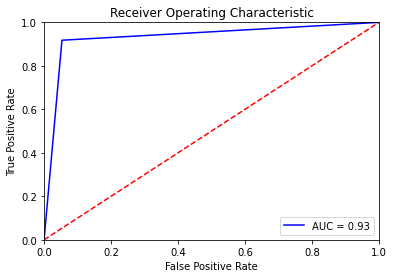

In [82]:
#AUC Curve
fpr, tpr, threshold = metrics.roc_curve(y_test, yhat_model_dtc)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

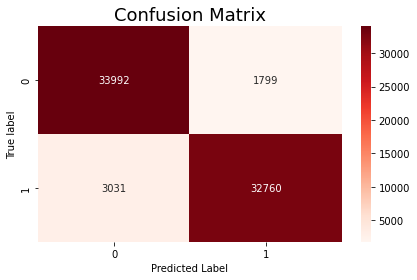

In [83]:
#Confusion Matrix
np.random.seed(2811)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
y_pred = cross_val_predict(model_dtc_tuned , x_train, y_train, cv = cv)


fig, ax = plt.subplots()
ax=sns.heatmap(confusion_matrix(y_train, y_pred), annot=True,ax=ax, fmt='d', cmap='Reds')
ax.set_title("Confusion Matrix", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

#10.0. DEPLOY MODEL TO PRODUCTION

##10.1. transformacoes class

In [84]:
'''import pandas as pd
import numpy  as np
import pickle


class transformations (object):  
  def __init__(self):
    self.Age=               pickle.load(open('parameters/Age_scaler.pkl','rb'))  
    self.Class=             pickle.load(open('parameters/Class_scaler.pkl','rb'))   
    self.CustomerType=      pickle.load(open('parameters/CustomerType_scaler.pkl','rb'))   
    self.FlightDistance=    pickle.load(open('parameters/FlightDistance_scaler.pkl','rb'))   
    self.InflightService=   pickle.load(open('parameters/In-flightService_scaler.pkl','rb'))   
    self.TypeOfTravel=      pickle.load(open('parameters/TypeOfTravel_scaler.pkl','rb'))   
           


  def data_cleaning(self,data): 

    columns=columns={  'Unnamed: 0'                       :'Unnamed: 0',
                       'id'                               :'Id',
                       'Gender'                           :'Gender',
                       'Customer Type'                    :'CustomerType',
                       'Age'                              :'Age',
                       'Type of Travel'                   :'TypeOfTravel',
                       'Class'                            :'Class',
                       'Flight Distance'                  :'FlightDistance',
                       'Inflight wifi service'            :'InflightWifiService',
                       'Departure/Arrival time convenient':'Departure/ArrivalTimeConvenient',
                       'Ease of Online booking'           :'EaseOfOnlineBooking',
                       'Gate location'                    :'GateLocation',
                       'Food and drink'                   :'FoodAndDrink',
                       'Online boarding'                  :'OnlineBoarding',
                       'Seat comfort'                     :'SeatComfort',
                       'Inflight entertainment'           :'InflightEntertainment',
                       'On-board service'                 :'On-boardService',
                       'Leg room service'                 :'LegRoomService',
                       'Baggage handling'                 :'BaggageHandling',
                       'Checkin service'                  :'CheckinService',
                       'Inflight service'                 :'InflightService',
                       'Cleanliness'                      :'Cleanliness',
                       'Departure Delay in Minutes'       :'DepartureDelayInMinutes',
                       'Arrival Delay in Minutes'         :'ArrivalDelayInMinutes'}
    data=data.rename(columns=columns)

    #to str
    aux=[ 'InflightWifiService','Departure/ArrivalTimeConvenient',
          'EaseOfOnlineBooking','GateLocation','Cleanliness',
          'FoodAndDrink','OnlineBoarding','SeatComfort',
          'InflightEntertainment','On-boardService',
          'LegRoomService','BaggageHandling',
          'CheckinService','InflightService']
    data[aux]=data[aux].astype(str)

    #to float
    data['DepartureDelayInMinutes']=data['DepartureDelayInMinutes'].astype(float)     

    return data
  
  
  def feature_engeneering(self,data):  

    #TotalScore
    lista=['InflightWifiService','Departure/ArrivalTimeConvenient','EaseOfOnlineBooking',
           'GateLocation','FoodAndDrink','OnlineBoarding','SeatComfort',
           'InflightEntertainment','On-boardService','LegRoomService',
           'BaggageHandling','CheckinService','InflightService','Cleanliness']

    data[lista]=data[lista].astype(int)
    data['TotalScore']=data[lista].sum(axis=1)

    #In-flightService
    data['In-flightService']=round((data['On-boardService']+data['InflightService'])/2,2)
    data[lista]=data[lista].astype(str)

    #SumOfDelays
    data['SumOfDelays']=data['DepartureDelayInMinutes']+data['ArrivalDelayInMinutes']  

    data=data.drop(['Unnamed: 0'],axis=1)

    return data  
  

  def data_preparation(self,data):  
    
    #MinMaxScaler
    #Age
    data['Age']=self.Age.fit_transform(data[['Age']].values)    

    #FlightDistance
    data['FlightDistance']=self.FlightDistance.fit_transform(data[['FlightDistance']].values)  

    #In-flightService
    data['In-flightService']=self.InflightService.fit_transform(data[['In-flightService']].values)


    #Ordinal Encoding
    r=0.166
    assortment_dict={'0':0*r,'1':1*r,'2':2*r,'3':3*r,'4':4*r,'5':5*r}

    #InflightWifiService   
    data['InflightWifiService']=data['InflightWifiService'].map(assortment_dict)

    #Departure/ArrivalTimeConvenient 
    data['Departure/ArrivalTimeConvenient']=data['Departure/ArrivalTimeConvenient'].map(assortment_dict) 

    #EaseOfOnlineBooking  
    data['EaseOfOnlineBooking']=data['EaseOfOnlineBooking'].map(assortment_dict) 

    #GateLocation
    data['GateLocation']=data['GateLocation'].map(assortment_dict)

    #FoodAndDrink  
    data['FoodAndDrink']=data['FoodAndDrink'].map(assortment_dict)

    #OnlineBoarding 
    data['OnlineBoarding']=data['OnlineBoarding'].map(assortment_dict) 

    #SeatComfort  
    data['SeatComfort']=data['SeatComfort'].map(assortment_dict)

    #InflightEntertainment
    data['InflightEntertainment']=data['InflightEntertainment'].map(assortment_dict) 

    #On-boardService
    data['On-boardService']=data['On-boardService'].map(assortment_dict)

    #LegRoomService
    data['LegRoomService']=data['LegRoomService'].map(assortment_dict)  

    #BaggageHandling 
    data['BaggageHandling']=data['BaggageHandling'].map(assortment_dict) 

    #CheckinService 
    data['CheckinService']=data['CheckinService'].map(assortment_dict) 

    #InflightService 
    data['InflightService']=data['InflightService'].map(assortment_dict)  

    #Cleanliness  
    data['Cleanliness']=data['Cleanliness'].map(assortment_dict) 

    #labelEncoder
    #CustomerType
    data['CustomerType']=self.CustomerType.fit_transform(data['CustomerType'])    

    #TypeOfTravel
    data['TypeOfTravel']=self.TypeOfTravel.fit_transform(data['TypeOfTravel'])    

    #Class
    data['Class']=self.Class.fit_transform(data['Class'])  
      
   
    return data[[     'CustomerType', 'Age', 'TypeOfTravel', 'Class', 'FlightDistance',
                    'InflightWifiService', 'GateLocation', 'OnlineBoarding', 'SeatComfort',
                    'InflightEntertainment', 'BaggageHandling', 'CheckinService',
                    'InflightService', 'Cleanliness', 'In-flightService']]
  


  def get_prediction( self,model, dado_original, data_transforme):

    #prediction
    pred=model.predict(data_transforme)

    #join pred into the original data
    dado_original['Predictions']=pred 

    return dado_original.to_json(orient='records',date_format='iso')'''

"import pandas as pd\nimport numpy  as np\nimport pickle\n\n\nclass transformations (object):  \n  def __init__(self):\n    self.Age=               pickle.load(open('parameters/Age_scaler.pkl','rb'))  \n    self.Class=             pickle.load(open('parameters/Class_scaler.pkl','rb'))   \n    self.CustomerType=      pickle.load(open('parameters/CustomerType_scaler.pkl','rb'))   \n    self.FlightDistance=    pickle.load(open('parameters/FlightDistance_scaler.pkl','rb'))   \n    self.InflightService=   pickle.load(open('parameters/In-flightService_scaler.pkl','rb'))   \n    self.TypeOfTravel=      pickle.load(open('parameters/TypeOfTravel_scaler.pkl','rb'))   \n           \n\n\n  def data_cleaning(self,data): \n\n    columns=columns={  'Unnamed: 0'                       :'Unnamed: 0',\n                       'id'                               :'Id',\n                       'Gender'                           :'Gender',\n                       'Customer Type'                    :'CustomerTy

##10.2. API Handler

In [85]:
'''from flask                           import Flask,request,Response
from transformations.transformations import transformations
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/model_dtc_tuned_train.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      test_raw=pd.DataFrame(test_json,index=[0])

    else:
      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())
    
    #Isntantiate transformations
    pipeline=transformations()  

    #data cleaning
    df1=pipeline.data_cleaning(test_raw)  

    #feature engeneering
    df2=pipeline.feature_engeneering(df1)

    #data preparation
    df3=pipeline.data_preparation(df2)

    #predict
    df_response=pipeline.get_prediction(model,test_raw,df3)
    
    return df_response

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                           import Flask,request,Response\nfrom transformations.transformations import transformations\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/model_dtc_tuned_train.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      test_raw=pd.DataFrame(test_json,index=[0])\n\n    else:\n      test_raw=pd.DataFrame(test_json,columns=test_json[0].keys())\n    \n    #Isntantiate transformations\n    pipeline=transformations()  \n\n    #data cleaning\n    df1=pipeline.data_cleaning(test_raw)  \n\n    #feature engeneering\n    df2=pipeline.feature_engeneering(df1)\n\n    #data preparation\n    df3=pipeline.data_preparation(df2)\n\n    #predict\n    df_response=pipeline.get_prediction(model,test_raw,df3)\n    \n    return df_response\n\n  else:

##10.3.API Tester

In [86]:
#converter em json
df_deploy=pd.read_csv('/content/test.csv')
df_deploy=df_deploy.drop(['satisfaction'],axis=1)
df_deploy=json.dumps(df_deploy.to_dict(orient='records'))

#API call
path='https://satis2.herokuapp.com'
url=path +'/oi'
headers={'content-type':'application/json'}
r=requests.post(url,data=df_deploy,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [87]:
#Prediction
df1=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df1.head(15)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Predictions
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,3,4,3,5,5,5,5,2,5,5,50,44.000,1
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,5,4,5,4,4,4,4,3,4,5,0,0.000,1
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,2,2,2,2,4,1,3,2,2,2,0,0.000,0
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,3,4,4,1,1,1,1,3,1,4,0,6.000,1
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,4,1,2,2,2,2,2,4,2,4,0,20.000,0
5,5,39177,Male,Loyal Customer,16,Business travel,Eco,311,3,3,3,3,5,5,3,5,4,3,1,1,2,5,0,0.000,1
6,6,79433,Female,Loyal Customer,77,Business travel,Business,3987,5,5,5,5,3,5,5,5,5,5,5,4,5,3,0,0.000,1
7,7,97286,Female,Loyal Customer,43,Business travel,Business,2556,2,2,2,2,4,4,5,4,4,4,4,5,4,3,77,65.000,1
8,8,27508,Male,Loyal Customer,47,Business travel,Eco,556,5,2,2,2,5,5,5,5,2,2,5,3,3,5,1,0.000,1
9,9,62482,Female,Loyal Customer,46,Business travel,Business,1744,2,2,2,2,3,4,4,4,4,4,4,5,4,4,28,14.000,1
